In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
  
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)
batched_predict = vmap(predict, in_axes=(None, 0))

In [3]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return [(w - step_size * dw, b - step_size * db)
              for (w, b), (dw, db) in zip(params, grads)]

In [4]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

2023-12-17 19:36:33.189548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 19:36:33.189616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 19:36:33.211805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 19:36:34.618721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-17 19:36:35.894651: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

In [5]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [6]:
import time

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in get_train_batches():
        x = jnp.reshape(x, (len(x), num_pixels))
        y = one_hot(y, num_labels)
        params = update(params, x, y)
    epoch_time = time.time() - start_time

    train_acc = accuracy(params, train_images, train_labels)
    test_acc = accuracy(params, test_images, test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

Epoch 0 in 4.98 sec
Training set accuracy 0.9253000020980835
Test set accuracy 0.9266999959945679
Epoch 1 in 4.00 sec
Training set accuracy 0.9428666830062866
Test set accuracy 0.9413999915122986
Epoch 2 in 4.01 sec
Training set accuracy 0.953166663646698
Test set accuracy 0.9514999985694885
Epoch 3 in 4.06 sec
Training set accuracy 0.9599666595458984
Test set accuracy 0.9557999968528748
Epoch 4 in 4.00 sec
Training set accuracy 0.9650999903678894
Test set accuracy 0.960599958896637
Epoch 5 in 4.01 sec
Training set accuracy 0.9690499901771545
Test set accuracy 0.9630999565124512
Epoch 6 in 3.96 sec
Training set accuracy 0.9724833369255066
Test set accuracy 0.965499997138977
Epoch 7 in 3.94 sec
Training set accuracy 0.9754166603088379
Test set accuracy 0.9666000008583069
Epoch 8 in 3.88 sec
Training set accuracy 0.9781500101089478
Test set accuracy 0.9682999849319458
Epoch 9 in 4.01 sec
Training set accuracy 0.9803333282470703
Test set accuracy 0.9691999554634094


In [7]:
def embed(params, image):
    activations = image
    # Get the outputs at the second to last layer, pre-activation:
    for w, b in params[:-2]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    return outputs

batched_embed = vmap(embed, in_axes=(None, 0))

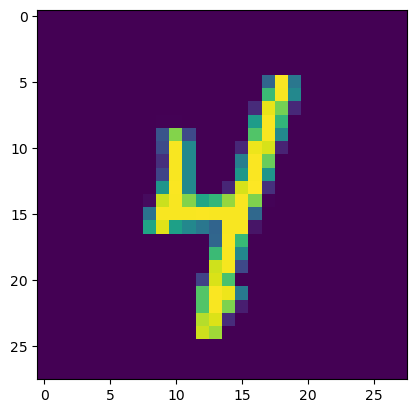

In [8]:
import matplotlib.pyplot as plt

example_image = train_images[0]

plt.imshow(example_image.reshape([28, 28]));

In [39]:
n_samples = 10_000
train_embeddings = batched_embed(params, train_images[:n_samples])

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA()
tsne = TSNE()
train_embeddings_pca = pca.fit_transform(train_embeddings)
train_embeddings_tsne = tsne.fit_transform(train_embeddings)

<Axes: >

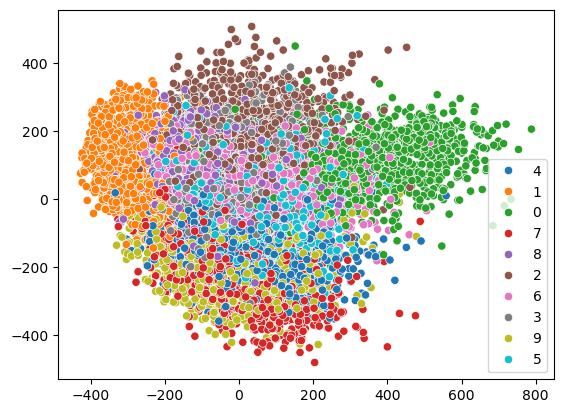

In [40]:
sns.scatterplot(x=train_embeddings_pca[:, 0], y=train_embeddings_pca[:, 1], hue=[str(num) for num in train_labels[:n_samples].argmax(1)])

<Axes: >

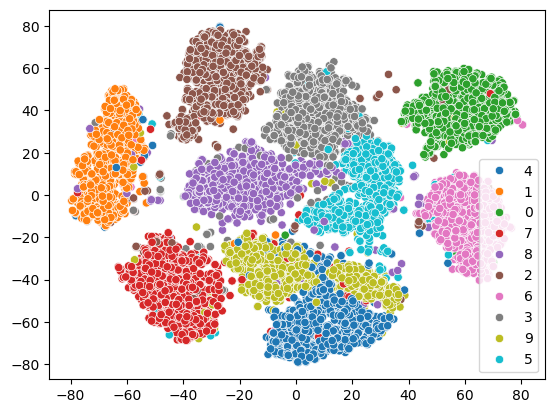

In [42]:
sns.scatterplot(x=train_embeddings_tsne[:, 0], y=train_embeddings_tsne[:, 1], hue=[str(num) for num in train_labels[:n_samples].argmax(1)])

In [44]:
jnp.save("train_data", train_embeddings)